In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def catboost_metric(model_cb, X_test, y_test ):
    y_pred_cb = model_cb.predict(X_test)
    y_pred_cb_proba = model_cb.predict_proba(X_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_pred_cb_proba)
    accuracy = accuracy_score(y_test, y_pred_cb)
    precision = precision_score(y_test, y_pred_cb)
    recall = recall_score(y_test, y_pred_cb)
    f1 = f1_score(y_test, y_pred_cb)

    metrics_cb = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc
        }
    return metrics_cb, y_pred_cb, y_pred_cb_proba

def lightgbm_metric( model, X_test, y_test):

    y_pred_lgb = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_lgb)   
    best_threshold = thresholds[(tpr - fpr).argmax()]
    print(best_threshold)

    roc_auc = roc_auc_score(y_test, y_pred_lgb)
    print(f'ROC AUC: {roc_auc:.4f}')
    y_pred = (y_pred_lgb >= best_threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    metrics = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc
        }
    return metrics, y_pred, y_pred_lgb

def plot_confusion_matrix(y_test, y_pred, title='Model'):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                cbar=False)
    plt.title(f'Confusion Matrix - {title}', fontsize=16, fontweight='bold')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()
    return plt


In [3]:
train = pd.read_csv('train.csv')
train.create_time = pd.to_datetime(train.create_time)
train.model_create_time = pd.to_datetime(train.model_create_time)

test = pd.read_csv('test.csv')
test.create_time = pd.to_datetime(test.create_time)
test.model_create_time = pd.to_datetime(test.model_create_time)

web = pd.read_csv('t1_webstat.csv')
web.sort_values('date_time', inplace=True)
web.date_time = pd.to_datetime(web.date_time)

In [4]:
display(web, train)


,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
2268917,109996122,1975-10-17 13:42:56.953,2,1,11.0,722.0,NaN,NaN,NaN,NaN
2268918,109996122,1975-10-17 13:43:07.510,2,2,22.0,7196.0,NaN,NaN,NaN,NaN
2268919,109996122,1975-10-17 13:43:29.860,2,3,25.0,779.0,NaN,NaN,NaN,NaN
2269206,109996122,1975-10-17 13:43:54.757,2,4,9.0,7196.0,NaN,NaN,NaN,NaN
2267445,109996122,1975-10-17 13:44:03.803,2,5,11.0,723.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2267023,134622417,1976-02-16 22:55:29.327,3,120,26.0,NaN,NaN,NaN,NaN,NaN
2267024,134622417,1976-02-16 22:55:55.497,1,121,17.0,4271.0,31165696.0,NaN,NaN,NaN
2078414,134622417,1976-02-16 22:56:12.727,2,122,159.0,4271.0,NaN,NaN,NaN,NaN
2000326,134622417,1976-02-16 22:58:51.717,7,123,51.0,NaN,NaN,NaN,NaN,NaN


,order_id,create_time,good_id,price,utm_medium,utm_source,sessionkey_id,category_id,parent_id,root_id,model_id,is_moderated,rating_value,rating_count,description_length,goods_qty,pics_qty,model_create_time,is_callcenter
0,1269921,1975-12-26 09:30:08,9896348,753,5,8.0,123777004,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,1
1,1270034,1975-12-26 10:28:57,9896348,753,1,2.0,123781654,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,0
2,1268272,1975-12-25 11:24:28,9896348,753,2,3.0,123591002,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,1
3,1270544,1975-12-26 14:16:06,9896348,753,1,1.0,123832302,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,1
4,1270970,1975-12-26 18:21:47,9896348,753,3,56.0,123881603,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104590,1250981,1975-12-16 12:11:32,68657110,1497,4,1.0,121795335,2873,1229,1183,35231362,1,4.0,3.0,1183,12,1,1976-01-23 00:08:20,1
104591,1173775,1975-11-08 11:29:50,60391507,1354,1,2.0,114277105,2873,1229,1183,35231362,1,4.0,3.0,1183,12,1,1976-01-23 00:08:20,1
104592,1180920,1975-11-12 09:14:35,66971400,1452,2,NaN,114972131,2873,1229,1183,35231362,1,4.0,3.0,1183,12,1,1976-01-23 00:08:20,0
104593,1177882,1975-11-10 17:28:07,60391498,1433,4,2.0,114672813,2873,1229,1183,35231362,1,4.0,3.0,1183,12,1,1976-01-23 00:08:20,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104595 entries, 0 to 104594
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   order_id            104595 non-null  int64         
 1   create_time         104595 non-null  datetime64[ns]
 2   good_id             104595 non-null  int64         
 3   price               104595 non-null  int64         
 4   utm_medium          104595 non-null  int64         
 5   utm_source          94145 non-null   float64       
 6   sessionkey_id       104595 non-null  int64         
 7   category_id         104595 non-null  int64         
 8   parent_id           104595 non-null  int64         
 9   root_id             104595 non-null  int64         
 10  model_id            104595 non-null  int64         
 11  is_moderated        104595 non-null  int64         
 12  rating_value        33741 non-null   float64       
 13  rating_count        51613 non

In [5]:
web.sessionkey_id.value_counts().iloc[15000:]

sessionkey_id
116061056    39
121033461    39
129158805    39
118543433    39
120435004    39
             ..
110062653     1
110154442     1
110153398     1
110152498     1
110151292     1
Name: count, Length: 313430, dtype: int64

In [6]:
# изучаем разные сессии... думаем, что бы еще такое намутить... отчего же может зависеть "звонок"..? что интересного перед нами..? 0_0
pd.options.display.max_rows = 100
web.query('sessionkey_id == 110040418')

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
2269208,110040418,1975-10-17 17:05:41.530,1,1,25.0,1200.0,1827718.0,10547740.0,726.0,1.0
2268920,110040418,1975-10-17 17:06:06.163,1,2,43.0,1200.0,1827718.0,10547740.0,726.0,1.0
2268630,110040418,1975-10-17 17:06:49.870,2,3,22.0,1200.0,NaN,NaN,NaN,NaN
2269209,110040418,1975-10-17 17:07:11.047,2,4,16.0,NaN,NaN,NaN,NaN,NaN
2268631,110040418,1975-10-17 17:07:27.843,2,5,18.0,1200.0,NaN,NaN,NaN,NaN
2267447,110040418,1975-10-17 17:07:45.243,1,6,55.0,1200.0,14122715.0,28114543.0,430.0,1.0
2267448,110040418,1975-10-17 17:08:40.190,3,7,20.0,NaN,NaN,NaN,NaN,NaN
2269210,110040418,1975-10-17 17:09:47.027,9,9,29.0,NaN,NaN,NaN,NaN,NaN
2268921,110040418,1975-10-17 17:10:16.837,1,10,281.0,1200.0,14122715.0,28114543.0,430.0,1.0
2268632,110040418,1975-10-17 17:14:57.973,2,11,36.0,NaN,NaN,NaN,NaN,NaN


In [5]:
# собираем агрегаты

# можно, например, так:
session_agg = web.groupby('sessionkey_id', sort=False).agg(
    product_sale_count=('product_in_sale', 'sum'),
    total_sec_dt=('date_time', lambda x: (x.iloc[-1] - x.iloc[0]).total_seconds()),
    total_sec_dur=('pageview_duration_sec', 'sum'),
    unique_pages_count=('pageview_number', 'nunique'),
    mean_sec_dur=('pageview_duration_sec', 'mean'),
    max_sec_dur=('pageview_duration_sec', 'max'),
    total_receipt=('price', 'sum') 
)

session_agg['sec_diff'] = session_agg['total_sec_dt'] - session_agg['total_sec_dur']

session_agg

,product_sale_count,total_sec_dt,total_sec_dur,unique_pages_count,mean_sec_dur,max_sec_dur,total_receipt,sec_diff
sessionkey_id,,,,,,,,
109996122,0.0,89.680,90.0,7,15.000000,25.0,0.0,-0.320
110019268,1.0,165.560,165.0,3,82.500000,122.0,2986.0,0.560
110020180,1.0,0.000,0.0,1,NaN,NaN,4490.0,0.000
110040418,4.0,591.490,545.0,11,54.500000,281.0,2312.0,46.490
110044482,1.0,0.000,0.0,1,NaN,NaN,4490.0,0.000
...,...,...,...,...,...,...,...,...
134626779,0.0,0.000,22.0,1,22.000000,22.0,0.0,-22.000
134627402,1.0,298.784,244.0,7,40.666667,109.0,411.0,54.784
134628420,0.0,273.624,93.0,5,23.250000,45.0,0.0,180.624


In [6]:
X_tr = train.merge(session_agg, how='left', on='sessionkey_id', sort=False)
X_tst = test.merge(session_agg, how='left', on='sessionkey_id', sort=False)

X = X_tr.drop(columns=['is_callcenter'])
y = X_tr['is_callcenter']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                      random_state=42, stratify=y)


<Axes: xlabel='is_callcenter', ylabel='sec_diff'>

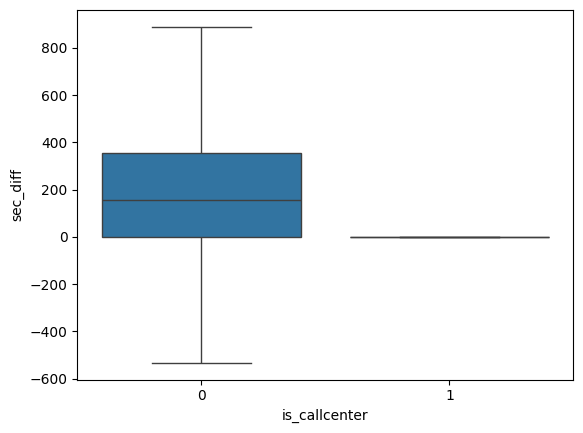

In [9]:

sns.boxplot(X_tr, y='sec_diff', x='is_callcenter', showfliers=False) # 0_0

<Axes: xlabel='is_callcenter', ylabel='total_receipt'>

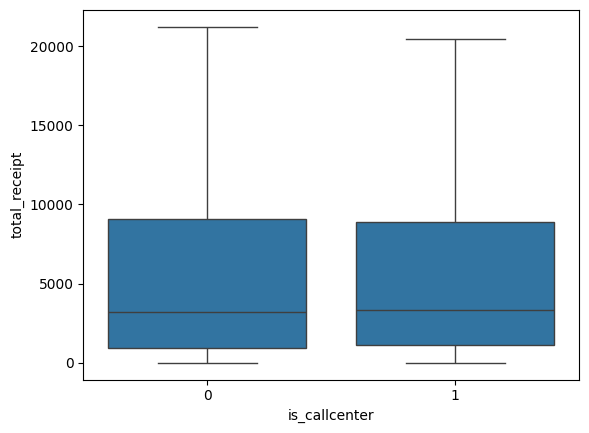

In [6]:
sns.boxplot(X_tr, y='max_sec_dur', x='is_callcenter', showfliers=False) # 0_0


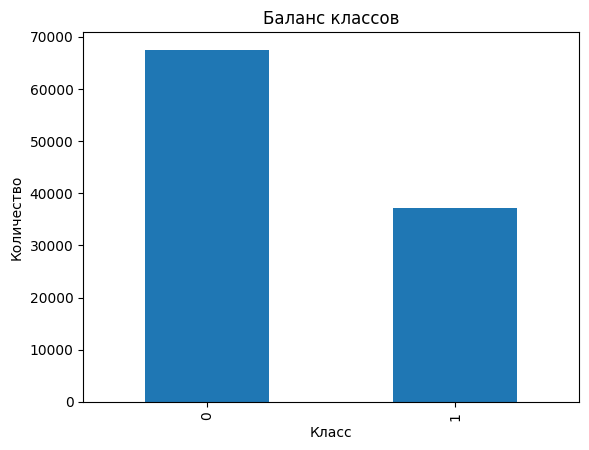

In [10]:
y.value_counts().plot(kind='bar')
plt.title("Баланс классов")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.show()

In [ ]:
import lightgbm as lgb

features = session_agg.columns

tr_data = lgb.Dataset(X_tr[features], label=X_tr.is_callcenter)
model_lgbm_baseline = lgb.train({'eta': 0.1, 'objective': 'binary'}, tr_data, num_boost_round=75)

y_tst = model_lgbm_baseline.predict(X_tst[features]) 

[LightGBM] [Info] Number of positive: 29679, number of negative: 53997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1826
[LightGBM] [Info] Number of data points in the train set: 83676, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.354690 -> initscore=-0.598489
[LightGBM] [Info] Start training from score -0.598489


In [70]:
metrics_baseline, y_pred, y_pred_proba = lightgbm_metric(model_lgbm_baseline, X_test[features], y_test)
print(metrics_baseline)

0.38255469994559704
ROC AUC: 0.8890
{'Accuracy': 0.8278598403365361, 'Precision': 0.7044651461612592, 'Recall': 0.8866576819407008, 'F1-Score': 0.7851303777075005, 'ROC-AUC': 0.8890326407326967}


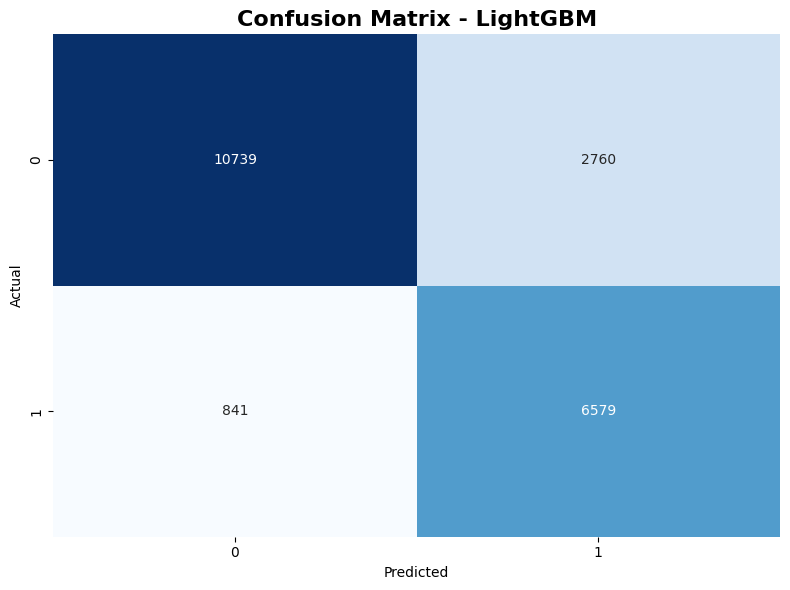

<module 'matplotlib.pyplot' from 'f:\\Машинное обучение с ментором\\Проект 1\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [9]:
plot_confusion_matrix(y_test, y_pred, title='LightGBM')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8697436	best: 0.8697436 (0)	total: 8.71ms	remaining: 4.95s
50:	test: 0.8859970	best: 0.8860097 (47)	total: 363ms	remaining: 3.69s
100:	test: 0.8862888	best: 0.8864017 (81)	total: 720ms	remaining: 3.34s
150:	test: 0.8864817	best: 0.8865626 (144)	total: 1.08s	remaining: 3s
200:	test: 0.8867525	best: 0.8867892 (193)	total: 1.44s	remaining: 2.64s
250:	test: 0.8868557	best: 0.8868557 (250)	total: 1.81s	remaining: 2.3s
300:	test: 0.8871886	best: 0.8871886 (300)	total: 2.19s	remaining: 1.95s
350:	test: 0.8871538	best: 0.8872243 (322)	total: 2.54s	remaining: 1.58s
400:	test: 0.8870837	best: 0.8872243 (322)	total: 2.9s	remaining: 1.22s
450:	test: 0.8871015	best: 0.8872243 (322)	total: 3.26s	remaining: 861ms
500:	test: 0.8872061	best: 0.8872450 (486)	total: 3.62s	remaining: 499ms
550:	test: 0.8872039	best: 0.8872529 (543)	total: 4s	remaining: 138ms
569:	test: 0.8872667	best: 0.8872943 (558)	total: 4.14s	remaining: 0us

bestTest = 0.887294262
bestIteration = 558

Shrink model to first 

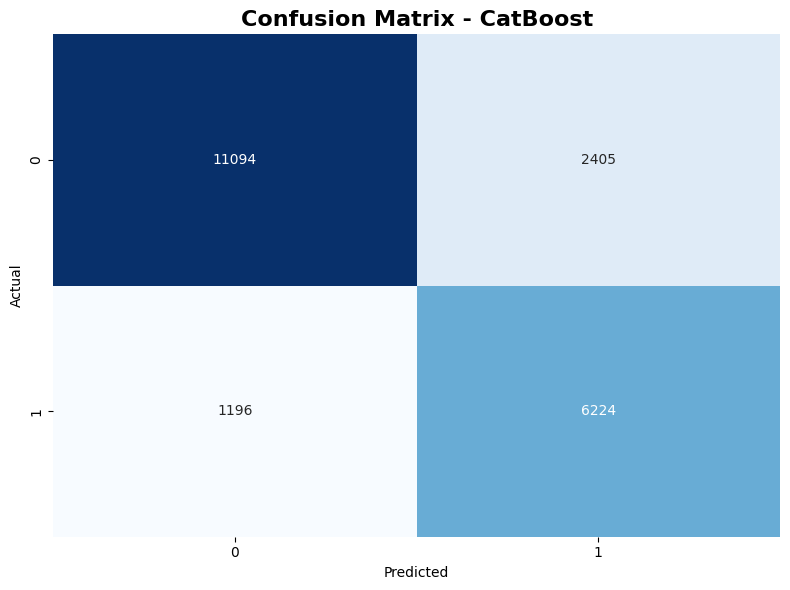

<module 'matplotlib.pyplot' from 'f:\\Машинное обучение с ментором\\Проект 1\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [71]:
from catboost import CatBoostClassifier, Pool


features = session_agg.columns

train_pool_baseline = Pool(X_train[features], y_train)
valid_pool_baseline = Pool(X_test[features], y_test)

model_cb_baseline = CatBoostClassifier(score_function='L2',
                              depth=5,
                              eta=0.15,
                              eval_metric='AUC',
                              iterations=570,
                              verbose=50)

model_cb_baseline.fit(train_pool_baseline, eval_set=valid_pool_baseline, plot=True)

metrics_cb_baseline, y_pred_cb, y_pred_cb_proba = catboost_metric(model_cb_baseline, X_test[features], y_test )
print(metrics_cb_baseline)
plot_confusion_matrix(y_test, y_pred_cb, title='CatBoost')


# Понижение размерности


Computing 2D t-SNE...


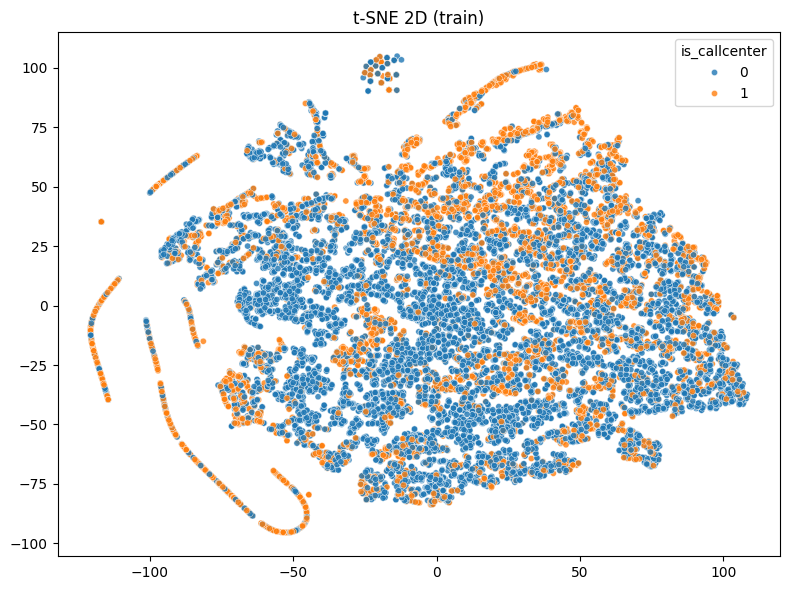

Computing 2D UMAP...


f:\Машинное обучение с ментором\Проект 1\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


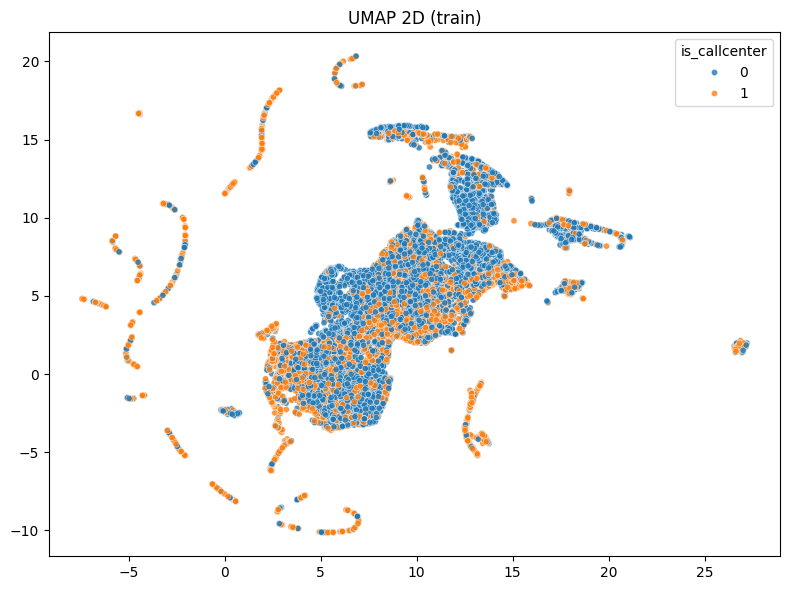

Computing 3D t-SNE (this may take a while)...


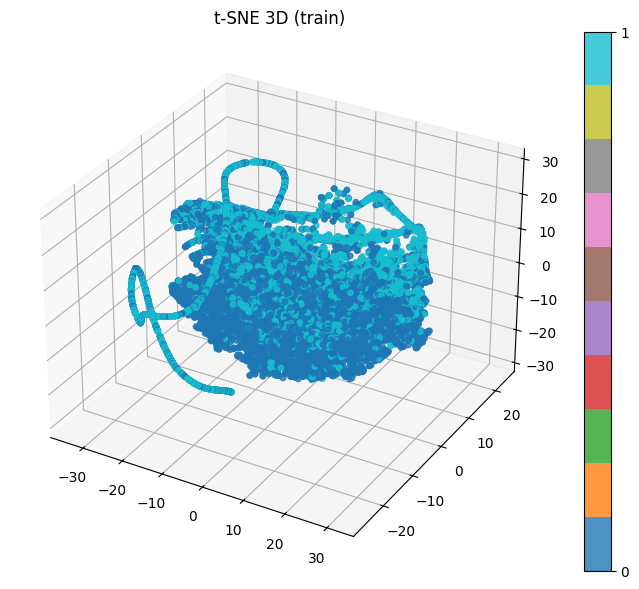

Computing 3D UMAP...


f:\Машинное обучение с ментором\Проект 1\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


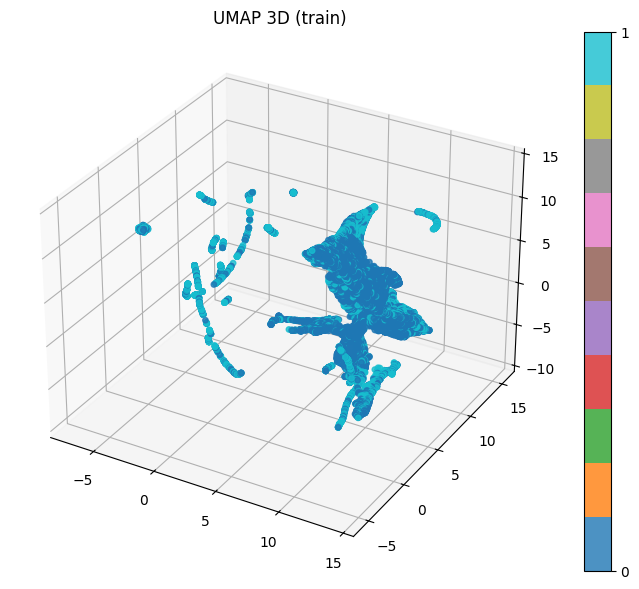

In [12]:
# Robust visualization cell: sampling, safe imports, and error handling
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import subprocess

# Ensure umap is available and import it robustly
try:
    import umap.umap_ as umap
except Exception:
    print('umap not found, installing umap-learn...')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'umap-learn'])
    import umap.umap_ as umap

sample_n = 20000 

features = session_agg.columns

X_vec = X[features].copy()
X_vec = X_vec.fillna(0)

# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_vec)

pca_n = min(50, X_scaled.shape[1])
pca = PCA(n_components=pca_n, random_state=42)
X_pca = pca.fit_transform(X_scaled)


y_plot = y.reset_index(drop=True) if hasattr(y, 'reset_index') else y
y_arr = np.asarray(y_plot)

# Optionally sample rows to speed up embeddings
n_samples = X_pca.shape[0]
if sample_n is not None and n_samples > sample_n:
    rng = np.random.RandomState(42)
    idx = rng.choice(n_samples, size=sample_n, replace=False)
    X_use = X_pca[idx]
    y_use = y_arr[idx]
else:
    X_use = X_pca
    y_use = y_arr


def safe_perplexity(n, default=30):
    max_p = max(5, (n - 1) // 3)
    return int(min(default, max_p)) if n > 10 else max(2, n-1)

# 2D t-SNE (may be slow on large data)
try:
    print('Computing 2D t-SNE...')
    perplex = safe_perplexity(X_use.shape[0])
    tsne2 = TSNE(n_components=2, perplexity=perplex, random_state=42, init='pca')
    X_tsne2 = tsne2.fit_transform(X_use)
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=X_tsne2[:,0], y=X_tsne2[:,1], hue=y_use, palette='tab10', s=20, alpha=0.8)
    plt.title('t-SNE 2D (train)')
    plt.legend(title='is_callcenter')
    plt.tight_layout()
    plt.savefig('tsne_2d.png', dpi=200, bbox_inches='tight')
    plt.show()
except Exception as e:
    print('t-SNE 2D failed:', e)

# 2D UMAP
try:
    print('Computing 2D UMAP...')
    umap2 = umap.UMAP(n_components=2, random_state=42)
    X_umap2 = umap2.fit_transform(X_use)
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=X_umap2[:,0], y=X_umap2[:,1], hue=y_use, palette='tab10', s=20, alpha=0.8)
    plt.title('UMAP 2D (train)')
    plt.legend(title='is_callcenter')
    plt.tight_layout()
    plt.savefig('umap_2d.png', dpi=200, bbox_inches='tight')
    plt.show()
except Exception as e:
    print('UMAP 2D failed:', e)

# 3D projections (may be slow) - run only if we have at least 3 samples
from mpl_toolkits.mplot3d import Axes3D
if X_use.shape[0] >= 3:
    try:
        print('Computing 3D t-SNE (this may take a while)...')
        perplex3 = safe_perplexity(X_use.shape[0])
        tsne3 = TSNE(n_components=3, perplexity=perplex3, random_state=42, init='pca')
        X_tsne3 = tsne3.fit_transform(X_use)
        fig = plt.figure(figsize=(9,7))
        ax = fig.add_subplot(111, projection='3d')
        sc = ax.scatter(X_tsne3[:,0], X_tsne3[:,1], X_tsne3[:,2], c=y_use, cmap='tab10', s=15, alpha=0.8)
        ax.set_title('t-SNE 3D (train)')
        plt.colorbar(sc, ticks=np.unique(y_use))
        plt.savefig('tsne_3d.png', dpi=200, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print('t-SNE 3D failed:', e)

    try:
        print('Computing 3D UMAP...')
        umap3 = umap.UMAP(n_components=3, random_state=42)
        X_umap3 = umap3.fit_transform(X_use)
        fig = plt.figure(figsize=(9,7))
        ax = fig.add_subplot(111, projection='3d')
        sc = ax.scatter(X_umap3[:,0], X_umap3[:,1], X_umap3[:,2], c=y_use, cmap='tab10', s=15, alpha=0.8)
        ax.set_title('UMAP 3D (train)')
        plt.colorbar(sc, ticks=np.unique(y_use))
        plt.savefig('umap_3d.png', dpi=200, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print('UMAP 3D failed:', e)
else:
    print('Not enough samples for 3D projections (need at least 3).')

# Кластеризация

In [75]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier, Pool
import lightgbm as lgb
from umap import UMAP


# ------------------------------------------------------
# 0) Берём только числовые признаки и выравниваем колонки
#    (никаких преобразований типов — просто отбор числовых)
# ------------------------------------------------------
X_train_num = X_train.select_dtypes(include=['number']).fillna(0)
X_test_num  = X_test.select_dtypes(include=['number']).reindex(columns=X_train_num.columns, fill_value=0).fillna(0)

# ------------------------------------------------------
# 1) Масштабирование + UMAP (fit на train, transform на test)
# ------------------------------------------------------
scaler = StandardScaler()
Xtr_scaled = scaler.fit_transform(X_train_num)
Xte_scaled = scaler.transform(X_test_num)

umap_model = UMAP(n_components=3, n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
Xtr_umap = umap_model.fit_transform(Xtr_scaled)   # только train
Xte_umap = umap_model.transform(Xte_scaled)       # test через transform

# ------------------------------------------------------
# 2) Кластеризация в UMAP-пространстве (fit только на train)
# ------------------------------------------------------
k = 6
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
kmeans.fit(Xtr_umap)

cluster_id_tr = kmeans.labels_
cluster_id_te = kmeans.predict(Xte_umap)

dist_tr = kmeans.transform(Xtr_umap)   # (n_train, k)
dist_te = kmeans.transform(Xte_umap)   # (n_test,  k)

# ------------------------------------------------------
# 3) OOF-частота таргета по кластерам (без ликиджа)
# ------------------------------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cluster_rate_oof = np.zeros(len(X_train_num), dtype=float)
y_tr_np = np.asarray(y_train)

for tr_idx, val_idx in skf.split(X_train_num, y_train):
    df_tr = pd.DataFrame({'c': cluster_id_tr[tr_idx], 'y': y_tr_np[tr_idx]})
    rate_map = df_tr.groupby('c')['y'].mean()
    global_rate = df_tr['y'].mean()
    val_c = pd.Series(cluster_id_tr[val_idx])
    cluster_rate_oof[val_idx] = val_c.map(rate_map).fillna(global_rate).values

# Для test берём частоты из полного train
df_full_tr = pd.DataFrame({'c': cluster_id_tr, 'y': y_tr_np})
rate_map_full = df_full_tr.groupby('c')['y'].mean()
global_rate_full = df_full_tr['y'].mean()
cluster_rate_te = pd.Series(cluster_id_te).map(rate_map_full).fillna(global_rate_full).values

# ------------------------------------------------------
# 4) Собираем финальные фичи (базовые + кластерные)
# ------------------------------------------------------
Xtr_feat = X_train_num.copy()
Xte_feat = X_test_num.copy()

Xtr_feat['cluster_id'] = cluster_id_tr
Xte_feat['cluster_id'] = cluster_id_te

for j in range(k):
    Xtr_feat[f'dist_c{j}'] = dist_tr[:, j]
    Xte_feat[f'dist_c{j}'] = dist_te[:, j]

Xtr_feat['cluster_rate'] = cluster_rate_oof
Xte_feat['cluster_rate'] = cluster_rate_te





f:\Машинное обучение с ментором\Проект 1\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [78]:
# ------------------------------------------------------
# 5) CatBoost (cluster_id как категориальный)
# ------------------------------------------------------

features_cluster = [
       'description_length', 'goods_qty', 'pics_qty',
       'product_sale_count', 'total_sec_dt', 'total_sec_dur',
       'unique_pages_count', 'mean_sec_dur', 'max_sec_dur', 'total_receipt',
       'sec_diff', 'cluster_id', 'dist_c0', 'dist_c1', 'dist_c2', 'dist_c3',
       'dist_c4', 'dist_c5', 'cluster_rate']

cat_cols = ['cluster_id']
train_pool_cluster = Pool(Xtr_feat[features_cluster], y_train, cat_features=cat_cols)
test_pool_cluster  = Pool(Xte_feat[features_cluster], y_test,  cat_features=cat_cols)

model_cb_cluster = CatBoostClassifier(depth=5, eta=0.15, 
                        loss_function='Logloss', eval_metric='AUC',
                        iterations=800, verbose=200,
                        random_seed=42)

model_cb_cluster.fit(train_pool_cluster, eval_set=test_pool_cluster, plot=True)

metrics_cb, y_pred_cb, y_pred_cb_proba = catboost_metric(model_cb_cluster, Xte_feat[features_cluster], y_test )
print(metrics_cb)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8605135	best: 0.8605135 (0)	total: 43.9ms	remaining: 35.1s
200:	test: 0.8887170	best: 0.8887170 (200)	total: 9.51s	remaining: 28.3s
400:	test: 0.8895282	best: 0.8895521 (397)	total: 18.6s	remaining: 18.5s
600:	test: 0.8893272	best: 0.8895668 (413)	total: 27.8s	remaining: 9.19s
799:	test: 0.8895740	best: 0.8895957 (666)	total: 36.8s	remaining: 0us

bestTest = 0.8895956554
bestIteration = 666

Shrink model to first 667 iterations.
{'Accuracy': 0.8290071227114106, 'Precision': 0.7313666465984346, 'Recall': 0.8185983827493262, 'F1-Score': 0.7725278219395867, 'ROC-AUC': 0.8895956553834775}


> Метрики baseline модели.

``` {'Accuracy': 0.8278598403365361, 'Precision': 0.7212886777146831, 'Recall': 0.8388140161725067, 'F1-Score': 0.775624649510873, 'ROC-AUC': 0.8872942619888585} ```

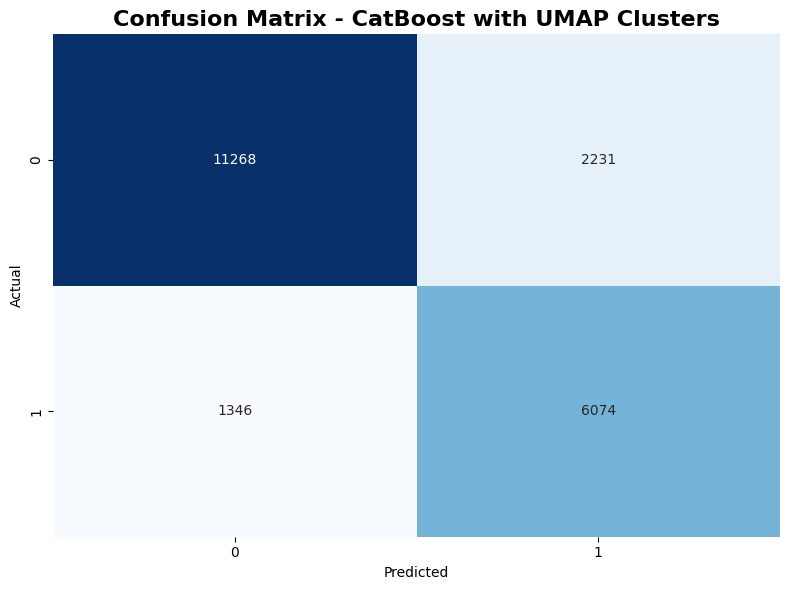

<module 'matplotlib.pyplot' from 'f:\\Машинное обучение с ментором\\Проект 1\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [79]:
plot_confusion_matrix(y_test, y_pred_cb, title='CatBoost with UMAP Clusters')

[LightGBM] [Warning] num_leaves is set=31, max_leaves=40 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_leaves is set=31, max_leaves=40 will be ignored. Current value: num_leaves=31
[LightGBM] [Info] Number of positive: 29679, number of negative: 53997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3790
[LightGBM] [Info] Number of data points in the train set: 83676, number of used features: 23
[LightGBM] [Warning] num_leaves is set=31, max_leaves=40 will be ignored. Current value: num_leaves=31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.354690 -> initscore=-0.598489
[LightGBM] [Info] Start training from score -0.598489
[LightGBM] [Warning] num_leaves is set=31, max_leaves=40 will be ignored. Current value: num_leaves=31
1.0
ROC AUC: 0.8310


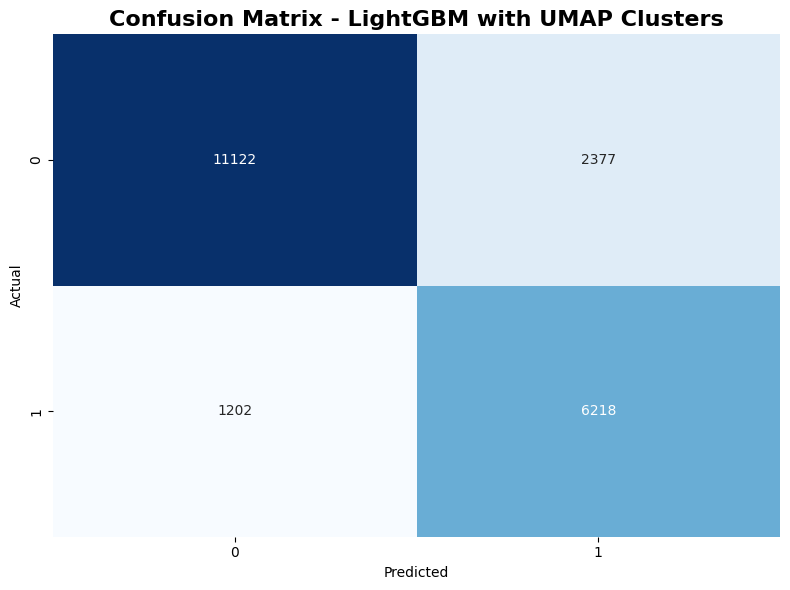

{'Accuracy': 0.8289115158468378, 'Precision': 0.7234438627108785, 'Recall': 0.8380053908355796, 'F1-Score': 0.7765220106150484, 'ROC-AUC': 0.8309591366356578}


In [17]:
# ------------------------------------------------------
# 6) LightGBM (cluster_id -> OHE)
# ------------------------------------------------------
Xtr_lgb = pd.get_dummies(Xtr_feat[features], columns=['cluster_id'], drop_first=True)
Xte_lgb = pd.get_dummies(Xte_feat[features], columns=['cluster_id'], drop_first=True)
Xte_lgb = Xte_lgb.reindex(columns=Xtr_lgb.columns, fill_value=0)

model_lgbm_clusters = lgb.LGBMClassifier(
    learning_rate=0.05, max_leaves=40,objective='binary'
)

model_lgbm_clusters.fit(Xtr_lgb, y_train, eval_set=[(Xte_lgb, y_test)], eval_metric='auc')
metrics_lgb, y_pred_lgb_bin, y_pred_lgb_proba = lightgbm_metric(model_lgbm_clusters, Xte_lgb, y_test)
plot_confusion_matrix(y_test, y_pred_lgb_bin, title='LightGBM with UMAP Clusters')
print(metrics_lgb)


> Метрики baseline модели.

```{'Accuracy': 0.8278598403365361, 'Precision': 0.7044651461612592, 'Recall': 0.8866576819407008, 'F1-Score': 0.7851303777075005, 'ROC-AUC': 0.8890326407326967}```


# Ближайшие соседи

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold  # или StratifiedKFold для классификации
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import SimpleImputer

def knn_features_oof(X_train_df, y_train, X_test_df, k=15, metric='euclidean',
                     n_splits=5, random_state=42, stratified=False):
    """
    Возвращает 3 OOF-фичи для train и такие же для test:
      - knn_ratio_k{k}: доля положительного класса среди k соседей (для классификации)
      - knn_mean_dist_k{k}: среднее расстояние до k соседей
      - knn_density_k{k}: 1 / расстояние до k-го соседа
    """

    # Сохраняем индексы до преобразований
    idx_tr = X_train_df.index
    idx_te = X_test_df.index

    # 1) Оставляем только числовые столбцы и выравниваем test по train
    Xnum_tr = X_train_df.select_dtypes(include=['number']).copy()
    Xnum_te = X_test_df.select_dtypes(include=['number']).reindex(columns=Xnum_tr.columns, fill_value=np.nan)

    # 2) Заменяем ±inf на NaN (чтобы имPUTер их увидел)
    Xnum_tr = Xnum_tr.replace([np.inf, -np.inf], np.nan)
    Xnum_te = Xnum_te.replace([np.inf, -np.inf], np.nan)

    # 3) Импутация пропусков: обучаем на TRAIN, применяем к TEST
    imputer = SimpleImputer(strategy='median')
    X_tr_imp = imputer.fit_transform(Xnum_tr.values)
    X_te_imp = imputer.transform(Xnum_te.values)


    # Масштабирование
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr_imp)
    X_te_scaled = scaler.transform(X_te_imp)

    # Вектор y — сразу NumPy (чтобы можно было индексировать 2-D массивом индексов соседей)
    y_arr = np.asarray(y_train)

    # Матрицы под OOF-фичи
    oof_ratio = np.zeros(len(Xnum_tr), dtype=float)
    oof_mean_dist = np.zeros(len(Xnum_tr), dtype=float)
    oof_density = np.zeros(len(Xnum_tr), dtype=float)

    # KFold или StratifiedKFold (на твой выбор)
    if stratified:
        from sklearn.model_selection import StratifiedKFold
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        split_iter = kf.split(X_tr_scaled, y_arr)
    else:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        split_iter = kf.split(X_tr_scaled)

    for tr_idx, val_idx in split_iter:
        X_tr_fold = X_tr_scaled[tr_idx]
        y_tr_fold = y_arr[tr_idx]
        X_val_fold = X_tr_scaled[val_idx]

        # Безопасный k на фолде
        k_fold = max(1, min(k, X_tr_fold.shape[0]))

        nn = NearestNeighbors(n_neighbors=k_fold, metric=metric, n_jobs=-1)
        nn.fit(X_tr_fold)
        dists, idxs = nn.kneighbors(X_val_fold, return_distance=True)  # dists, idxs: (n_val, k_fold)

        # Доля класса 1 среди соседей (для регрессии можно заменить на среднее значения y)
        neigh_labels = y_tr_fold[idxs]        # (n_val, k_fold)
        ratio = neigh_labels.mean(axis=1)     # (n_val,)

        mean_dist = dists.mean(axis=1)        # (n_val,)
        density   = 1.0 / (dists[:, -1] + 1e-8)

        oof_ratio[val_idx]     = ratio
        oof_mean_dist[val_idx] = mean_dist
        oof_density[val_idx]   = density

    # Применение к TEST: ищем соседей по всему трейну
    k_full = max(1, min(k, X_tr_scaled.shape[0]))
    nn_full = NearestNeighbors(n_neighbors=k_full, metric=metric, n_jobs=-1)
    nn_full.fit(X_tr_scaled)
    d_te, i_te = nn_full.kneighbors(X_te_scaled, return_distance=True)

    te_ratio     = y_arr[i_te].mean(axis=1)
    te_mean_dist = d_te.mean(axis=1)
    te_density   = 1.0 / (d_te[:, -1] + 1e-8)

    # Собираем DataFrame с ИСХОДНЫМИ индексами
    X_train_new = pd.DataFrame({
        f'knn_ratio_k{k}':     oof_ratio,
        f'knn_mean_dist_k{k}': oof_mean_dist,
        f'knn_density_k{k}':   oof_density
    }, index=idx_tr)

    X_test_new = pd.DataFrame({
        f'knn_ratio_k{k}':     te_ratio,
        f'knn_mean_dist_k{k}': te_mean_dist,
        f'knn_density_k{k}':   te_density
    }, index=idx_te)

    return X_train_new, X_test_new


features = session_agg.columns

X_tr_knn, X_te_knn = knn_features_oof(X_train[features], y_train, X_test[features], k=15)

# затем конкатенируй с исходными фичами
Xtr_final = pd.concat([X_train[features], X_tr_knn], axis=1)
Xte_final = pd.concat([X_test[features],  X_te_knn], axis=1)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8663887	best: 0.8663887 (0)	total: 7.89ms	remaining: 4.49s
50:	test: 0.8859555	best: 0.8859555 (50)	total: 410ms	remaining: 4.17s
100:	test: 0.8866481	best: 0.8867241 (81)	total: 811ms	remaining: 3.77s
150:	test: 0.8868953	best: 0.8868953 (150)	total: 1.22s	remaining: 3.37s
200:	test: 0.8866665	best: 0.8869488 (172)	total: 1.62s	remaining: 2.97s
250:	test: 0.8866236	best: 0.8869488 (172)	total: 2.03s	remaining: 2.58s
300:	test: 0.8865037	best: 0.8869488 (172)	total: 2.44s	remaining: 2.18s
350:	test: 0.8865543	best: 0.8869488 (172)	total: 2.84s	remaining: 1.77s
400:	test: 0.8864892	best: 0.8869488 (172)	total: 3.26s	remaining: 1.37s
450:	test: 0.8862963	best: 0.8869488 (172)	total: 3.66s	remaining: 967ms
500:	test: 0.8862728	best: 0.8869488 (172)	total: 4.08s	remaining: 562ms
550:	test: 0.8860198	best: 0.8869488 (172)	total: 4.48s	remaining: 155ms
569:	test: 0.8858894	best: 0.8869488 (172)	total: 4.63s	remaining: 0us

bestTest = 0.8869487937
bestIteration = 172

Shrink model 

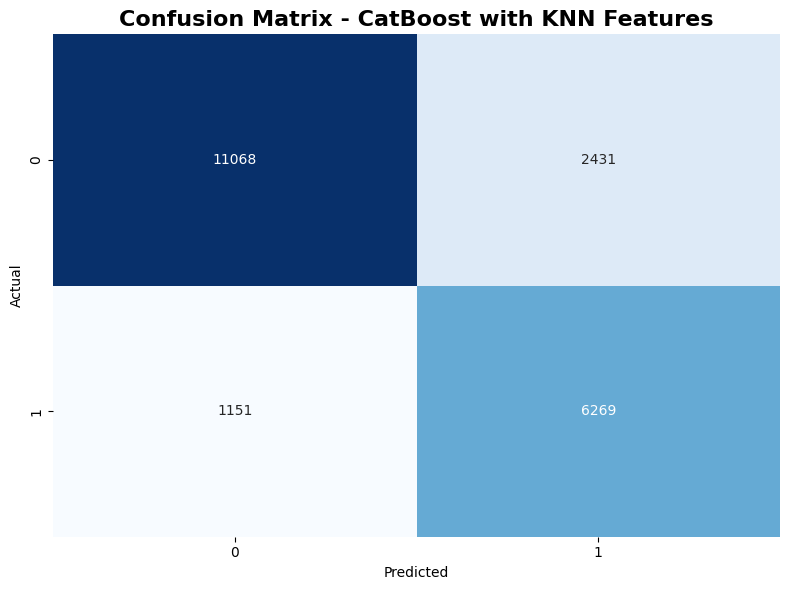

{'Accuracy': 0.8287681055499785, 'Precision': 0.7205747126436781, 'Recall': 0.8448787061994609, 'F1-Score': 0.7777915632754342, 'ROC-AUC': 0.8869487936512817}


In [19]:
train_pool = Pool(Xtr_final, y_train)
valid_pool = Pool(Xte_final, y_test)

model_cb_knn = CatBoostClassifier(score_function='L2',
                              depth=5,
                              eta=0.15,
                              eval_metric='AUC',
                              iterations=570,
                              verbose=50)

model_cb_knn.fit(train_pool, eval_set=valid_pool, plot=True)

metrics_cb, y_pred_cb, y_pred_cb_proba = catboost_metric(model_cb_knn, Xte_final, y_test )
plot_confusion_matrix(y_test, y_pred_cb, title='CatBoost with KNN Features')
print(metrics_cb)


> Метрики baseline модели.

``` {'Accuracy': 0.8278598403365361, 'Precision': 0.7212886777146831, 'Recall': 0.8388140161725067, 'F1-Score': 0.775624649510873, 'ROC-AUC': 0.8872942619888585} ```

[LightGBM] [Info] Number of positive: 29679, number of negative: 53997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2352
[LightGBM] [Info] Number of data points in the train set: 83676, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.354690 -> initscore=-0.598489
[LightGBM] [Info] Start training from score -0.598489
0.31071134522946553
ROC AUC: 0.8879


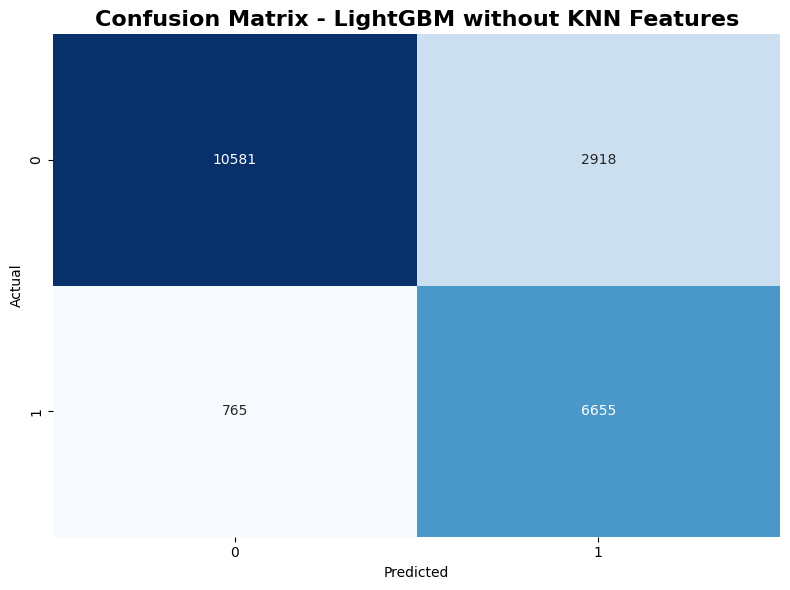

{'Accuracy': 0.8239399588890483, 'Precision': 0.6951843727149274, 'Recall': 0.8969002695417789, 'F1-Score': 0.7832636968163361, 'ROC-AUC': 0.8879280865169407}


In [20]:
import lightgbm as lgb

features = session_agg.columns

tr_data = lgb.Dataset(Xtr_final, label=y_train)
model_lgbm_knn = lgb.train({'eta': 0.05, 'objective': 'binary', 'max_leaves': 40}, tr_data, num_boost_round=500)
metrics, y_pred, y_pred_proba = lightgbm_metric(model_lgbm_knn, Xte_final, y_test)
plot_confusion_matrix(y_test, y_pred, title='LightGBM without KNN Features')
print(metrics)

> Метрики baseline модели.

```{'Accuracy': 0.8278598403365361, 'Precision': 0.7044651461612592, 'Recall': 0.8866576819407008, 'F1-Score': 0.7851303777075005, 'ROC-AUC': 0.8890326407326967}```


# Lightgbm: model.trees_to_dataframe

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем DataFrame деревьев
# tree_df = booster.trees_to_dataframe()

def visualize_tree_splits(tree_df, title):
    feature_counts = tree_df['split_feature'].value_counts()
    main_feature = feature_counts.index[0]
    main_feature_splits = tree_df.loc[tree_df['split_feature'] == main_feature, 'threshold']

    fig, axes = plt.subplots(3, 1, figsize=(10, 10))

    fig.suptitle(f"{title}", fontsize=16, fontweight='bold')
    sns.barplot(x=feature_counts.index, y=feature_counts.values, palette="viridis", ax=axes[0])
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
    axes[0].set_title('Частота использования признаков в split-ах')
    axes[0].set_ylabel('Число split-ов')
    axes[0].set_xlabel('Признак')

    sns.histplot(main_feature_splits, bins=20, color='orange', ax=axes[1])
    axes[1].set_title(f'Пороги split для признака {main_feature}')
    axes[1].set_xlabel('Порог split')
    axes[1].set_ylabel('Частота')
    
    gain_means = tree_df.groupby('split_feature')['split_gain'].mean().sort_values(ascending=False).head(15)
    sns.barplot(x=gain_means.values, y=gain_means.index, palette='mako')
    axes[2].set_title('Средний прирост (gain) по признакам')
    axes[2].set_xlabel('Средний split_gain')
    axes[2].set_ylabel('Признак')

    plt.tight_layout()
    plt.show()


C:\Users\Armen\AppData\Local\Temp\ipykernel_32472\2033980919.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_counts.index, y=feature_counts.values, palette="viridis", ax=axes[0])
C:\Users\Armen\AppData\Local\Temp\ipykernel_32472\2033980919.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
C:\Users\Armen\AppData\Local\Temp\ipykernel_32472\2033980919.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gain_means.values, y=gain_means.index, palette='mako')


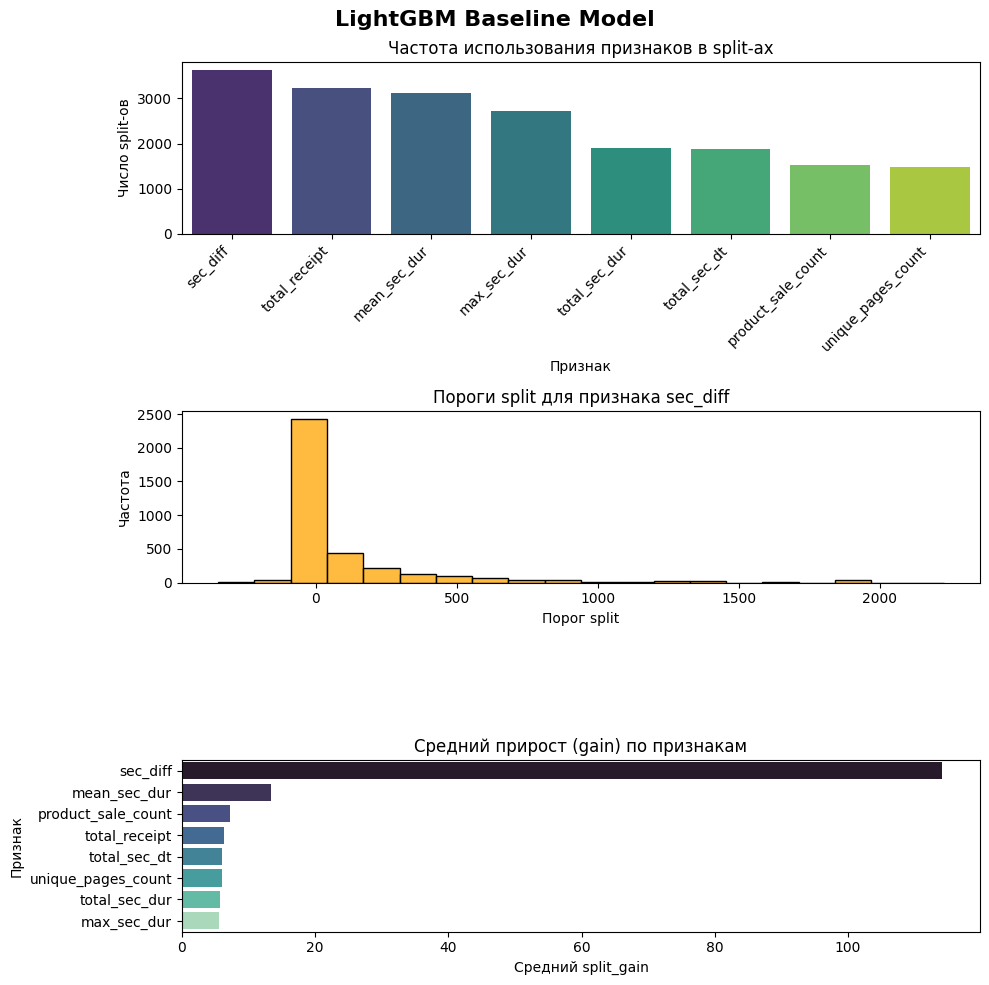

C:\Users\Armen\AppData\Local\Temp\ipykernel_32472\2033980919.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_counts.index, y=feature_counts.values, palette="viridis", ax=axes[0])
C:\Users\Armen\AppData\Local\Temp\ipykernel_32472\2033980919.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
C:\Users\Armen\AppData\Local\Temp\ipykernel_32472\2033980919.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gain_means.values, y=gain_means.index, palette='mako')


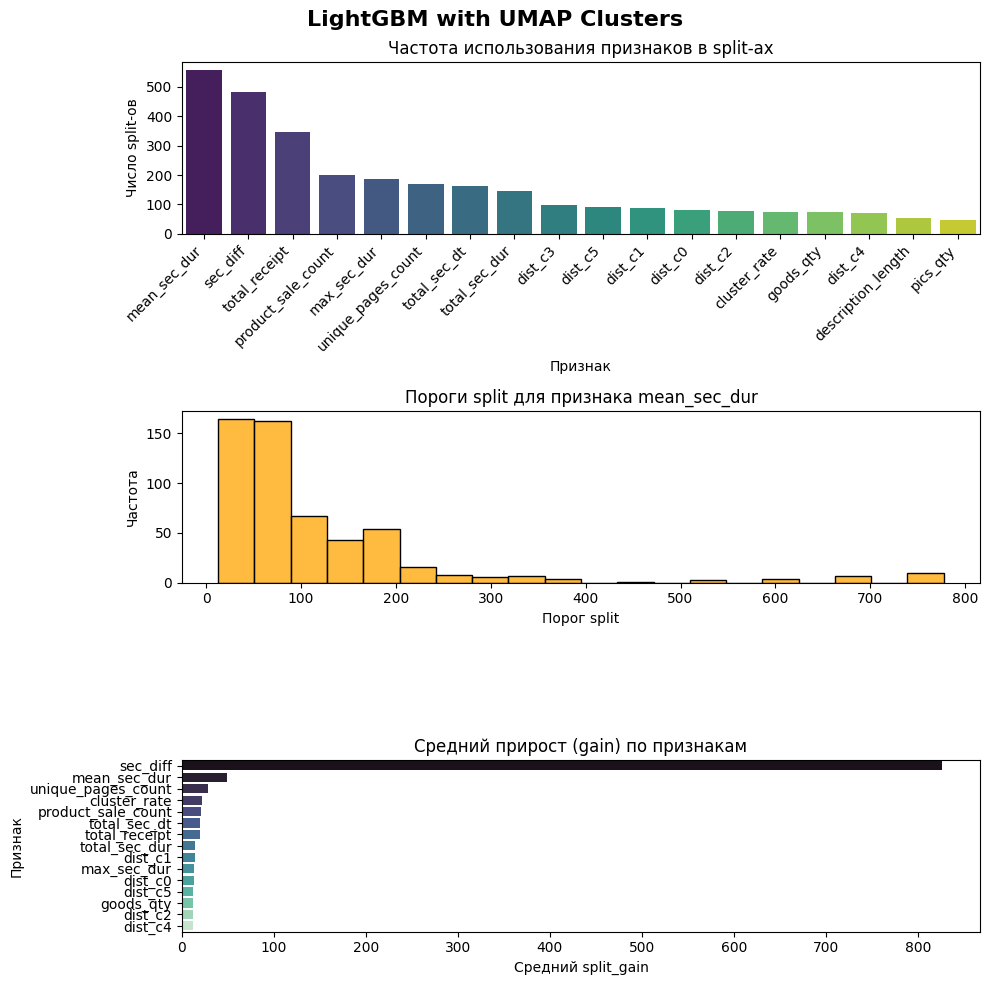

C:\Users\Armen\AppData\Local\Temp\ipykernel_32472\2033980919.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_counts.index, y=feature_counts.values, palette="viridis", ax=axes[0])
C:\Users\Armen\AppData\Local\Temp\ipykernel_32472\2033980919.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
C:\Users\Armen\AppData\Local\Temp\ipykernel_32472\2033980919.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gain_means.values, y=gain_means.index, palette='mako')


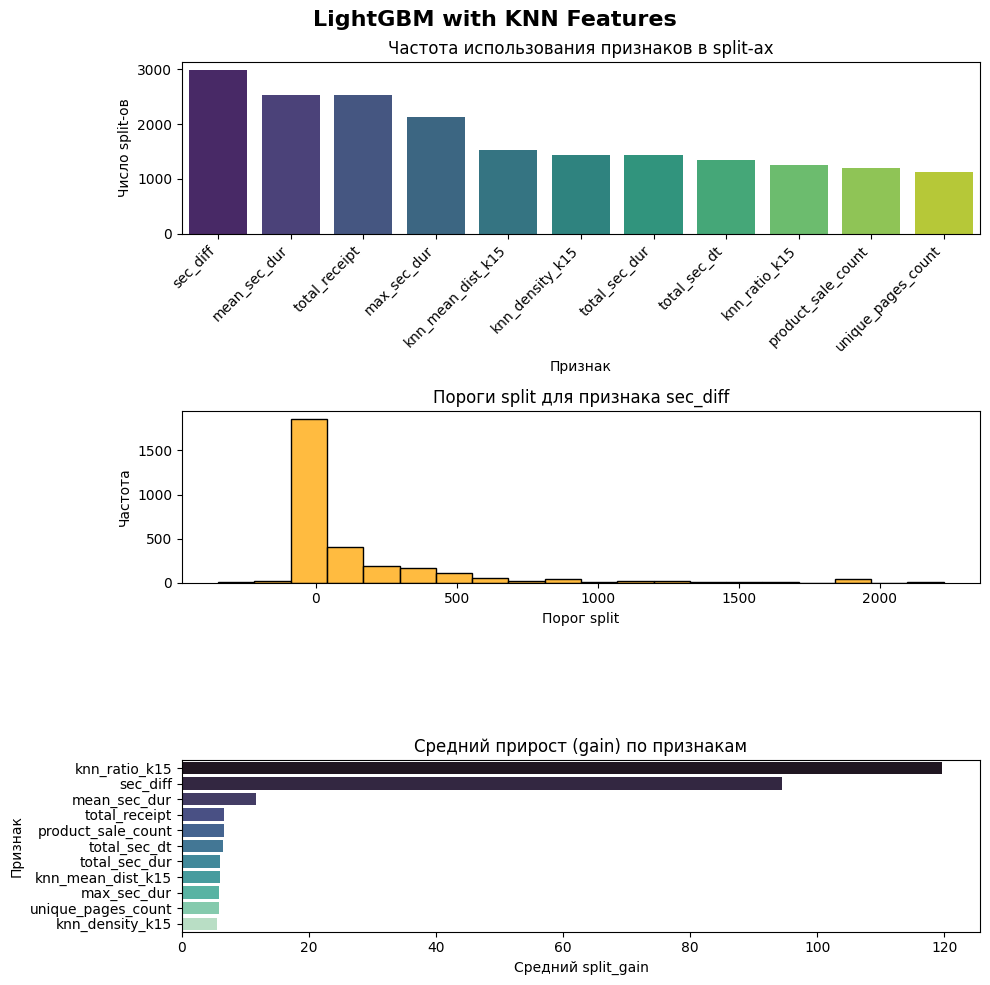

In [22]:

tree_df_cluster = model_lgbm_clusters.booster_.trees_to_dataframe()
tree_df = model_lgbm_baseline.trees_to_dataframe()
tree_df_knn = model_lgbm_knn.trees_to_dataframe()


visualize_tree_splits(tree_df, title='LightGBM Baseline Model')
visualize_tree_splits(tree_df_cluster, title='LightGBM with UMAP Clusters')
visualize_tree_splits(tree_df_knn, title='LightGBM with KNN Features')

# get_object_importance

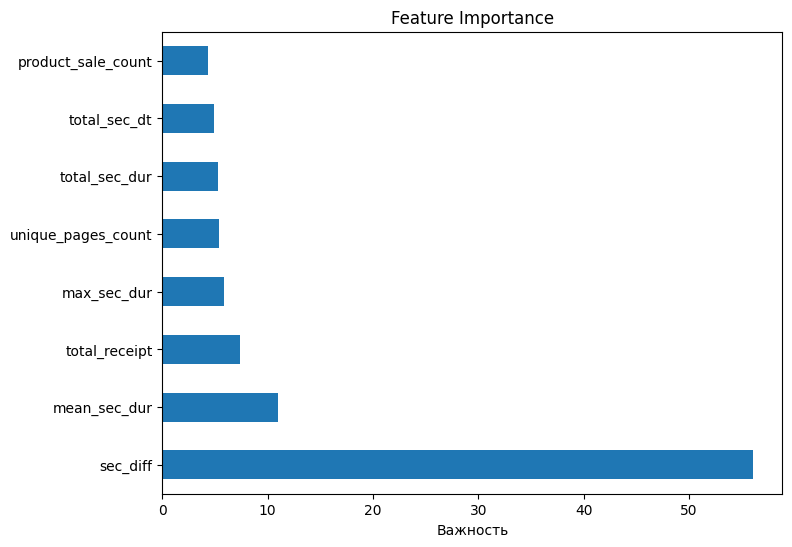

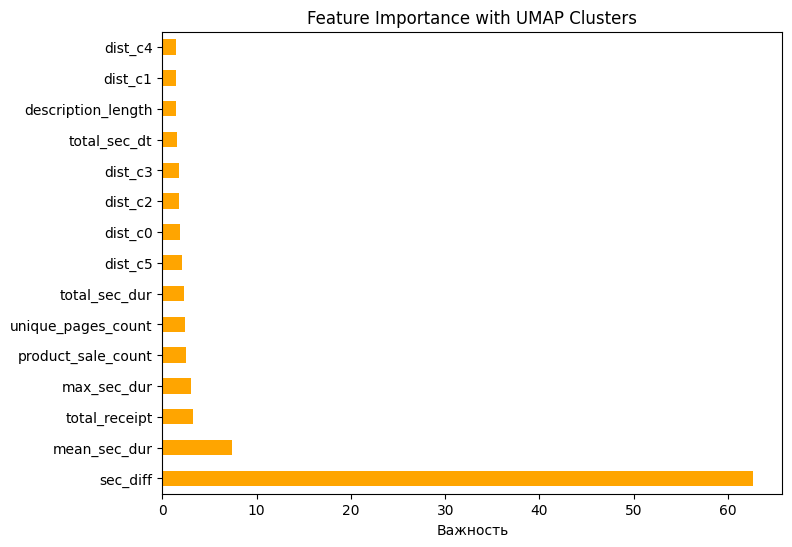

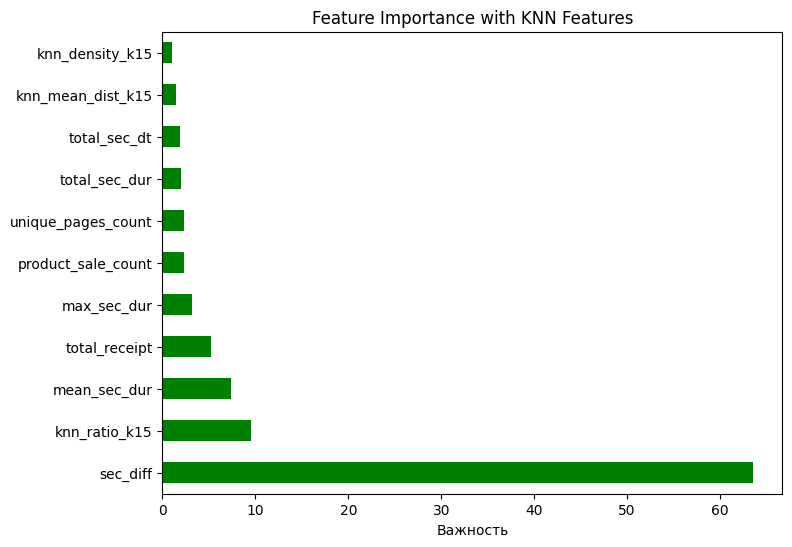

In [56]:
importances = pd.Series(model_cb_baseline.feature_importances_, index=features)
impot_cluster = pd.Series(model_cb_cluster.feature_importances_, index=features_cluster)
impot_knn = pd.Series(model_cb_knn.feature_importances_, index=Xtr_final.columns)

# Визуализируем
importances.nlargest(10).plot(kind='barh', figsize=(8, 6))
plt.title('Feature Importance')
plt.xlabel('Важность')
plt.show()

impot_cluster.nlargest(15).plot(kind='barh', figsize=(8, 6), color='orange')
plt.title('Feature Importance with UMAP Clusters')
plt.xlabel('Важность')
plt.show()

impot_knn.nlargest(15).plot(kind='barh', figsize=(8, 6), color='green')
plt.title('Feature Importance with KNN Features')
plt.xlabel('Важность')
plt.show()



In [25]:
train_pool_baseline = Pool(X_train[features].head(1000), y_train.head(1000))
valid_pool_baseline = Pool(X_test[features].head(1000), y_test.head(1000))

obj_imp = model_cb_baseline.get_object_importance(train_pool_baseline, valid_pool_baseline, top_size=5)
print(obj_imp)

([514, 595, 270, 756, 135], [-0.028300497755036045, -0.026563341797158586, -0.026255296314717666, -0.025839516081703984, 0.025229056248070755])


# SHAP

In [39]:
import shap
import matplotlib.pyplot as plt
import numpy as np

## Baseline Lightgbm

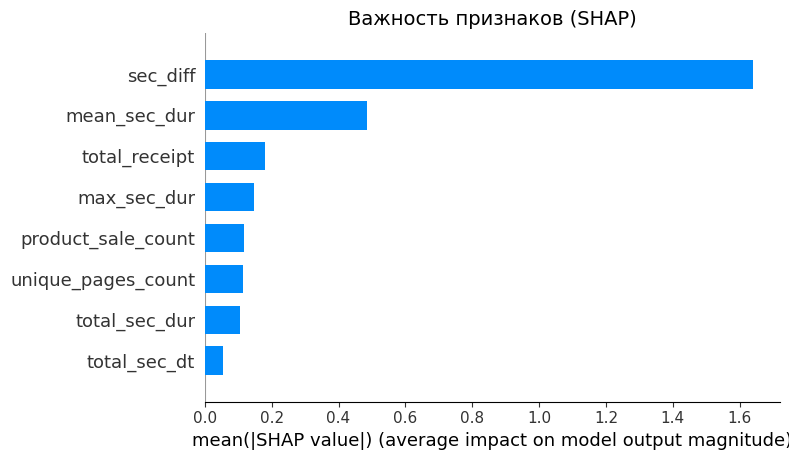

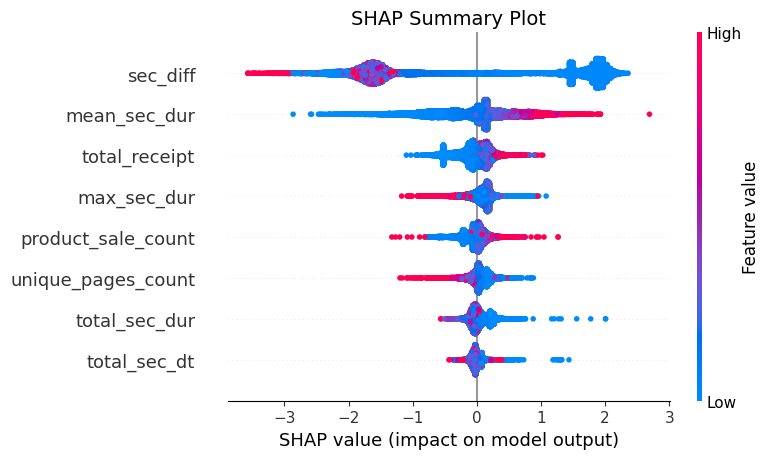

In [ ]:
# features — список твоих колонок (убеждаемся, что в тесте они есть)
Xte = X_test[features]

explainer = shap.TreeExplainer(model_lgbm_baseline)          # или cb для CatBoost
ex = explainer(Xte)                           # <-- возвращает shap.Explanation

# --- 1. Bar plot (средние абсолютные значения) ---
shap.summary_plot(ex, Xte, plot_type="bar", show=False)
plt.title("Важность признаков (SHAP)", fontsize=14)
plt.tight_layout()
plt.show()

# --- 2. Dot plot (распределение влияния) ---
shap.summary_plot(ex, Xte, plot_type="dot", show=False)
plt.title("SHAP Summary Plot", fontsize=14)
plt.tight_layout()
plt.show()

## Baseline Catboost

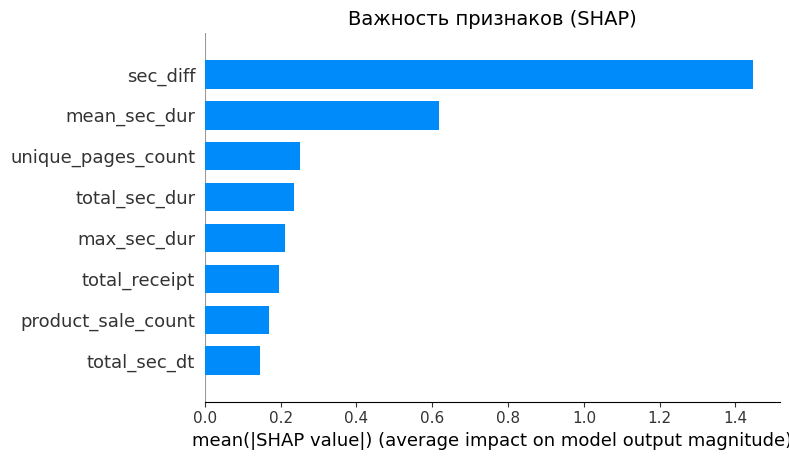

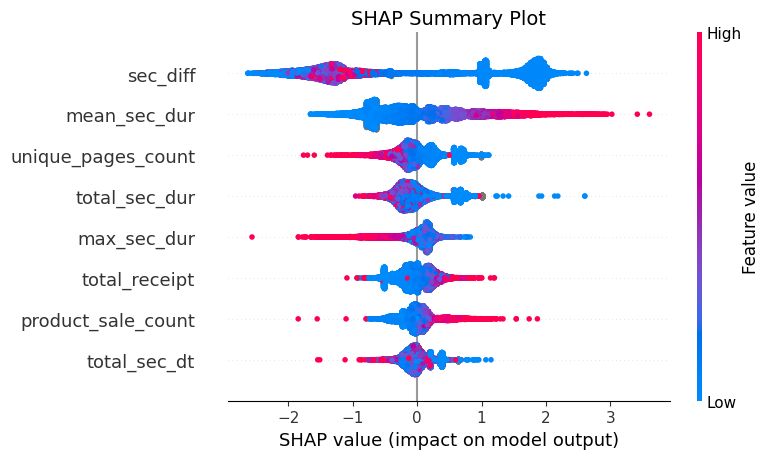

In [49]:
# features — список твоих колонок (убеждаемся, что в тесте они есть)
Xte = X_test[features]

explainer = shap.TreeExplainer(model_cb_baseline)          # или cb для CatBoost
ex = explainer(Xte)                           # <-- возвращает shap.Explanation

# --- 1. Bar plot (средние абсолютные значения) ---
shap.summary_plot(ex, Xte, plot_type="bar", show=False)
plt.title("Важность признаков (SHAP)", fontsize=14)
plt.tight_layout()
plt.show()

# --- 2. Dot plot (распределение влияния) ---
shap.summary_plot(ex, Xte, plot_type="dot", show=False)
plt.title("SHAP Summary Plot", fontsize=14)
plt.tight_layout()
plt.show()

## Попытки улучшения модели


In [60]:
features_new = [
       'product_sale_count', 'total_sec_dur',
       'unique_pages_count', 'mean_sec_dur', 'max_sec_dur', 'total_receipt',
       'sec_diff', 'knn_ratio_k15']

X_train_final = Xtr_final[features_new].copy().fillna(0)
X_test_final = Xte_final[features_new].copy().fillna(0)

In [62]:
display(X_train_final.head(), X_test_final.head())

X_train_final['log_total_receipt'] = np.log1p(X_train_final['total_receipt'])
X_test_final['log_total_receipt'] = np.log1p(X_test_final['total_receipt'])

X_train_final['total_sec_dur_log'] = np.log1p(X_train_final['total_sec_dur'])
X_test_final['total_sec_dur_log'] = np.log1p(X_test_final['total_sec_dur'])

X_train_final.drop(columns=['total_receipt', 'total_sec_dur'], inplace=True)
X_test_final.drop(columns=['total_receipt', 'total_sec_dur'], inplace=True)

X_train_final.head()

,product_sale_count,total_sec_dur,unique_pages_count,mean_sec_dur,max_sec_dur,total_receipt,sec_diff,knn_ratio_k15
98091,1.0,0.0,1.0,0.000000,0.0,216.0,0.000,0.466667
88772,5.0,117.0,9.0,14.625000,36.0,6348.0,719.993,0.000000
65898,7.0,962.0,17.0,60.125000,316.0,9373.0,200.470,0.133333
51481,6.0,500.0,10.0,55.555556,100.0,4988.0,0.093,0.666667
65976,1.0,273.0,4.0,68.250000,193.0,888.0,-192.913,0.000000


,product_sale_count,total_sec_dur,unique_pages_count,mean_sec_dur,max_sec_dur,total_receipt,sec_diff,knn_ratio_k15
21119,1.0,55.0,5.0,13.750000,17.0,796.0,169.114,0.066667
9741,18.0,7803.0,65.0,121.921875,937.0,83603.0,0.046,0.400000
11818,1.0,198.0,2.0,198.000000,198.0,1363.0,-0.180,0.666667
25295,0.0,211.0,11.0,21.100000,59.0,0.0,234.167,0.000000
60126,62.0,4864.0,131.0,37.415385,1126.0,11669.0,614.520,0.066667


f:\Машинное обучение с ментором\Проект 1\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
f:\Машинное обучение с ментором\Проект 1\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
f:\Машинное обучение с ментором\Проект 1\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
f:\Машинное обучение с ментором\Проект 1\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,product_sale_count,unique_pages_count,mean_sec_dur,max_sec_dur,sec_diff,knn_ratio_k15,log_total_receipt,total_sec_dur_log
98091,1.0,1.0,0.000000,0.0,0.000,0.466667,5.379897,0.000000
88772,5.0,9.0,14.625000,36.0,719.993,0.000000,8.756053,4.770685
65898,7.0,17.0,60.125000,316.0,200.470,0.133333,9.145695,6.870053
51481,6.0,10.0,55.555556,100.0,0.093,0.666667,8.514991,6.216606
65976,1.0,4.0,68.250000,193.0,-192.913,0.000000,6.790097,5.613128


[LightGBM] [Info] Number of positive: 29679, number of negative: 53997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1585
[LightGBM] [Info] Number of data points in the train set: 83676, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.354690 -> initscore=-0.598489
[LightGBM] [Info] Start training from score -0.598489
0.37348711270305185
ROC AUC: 0.8886


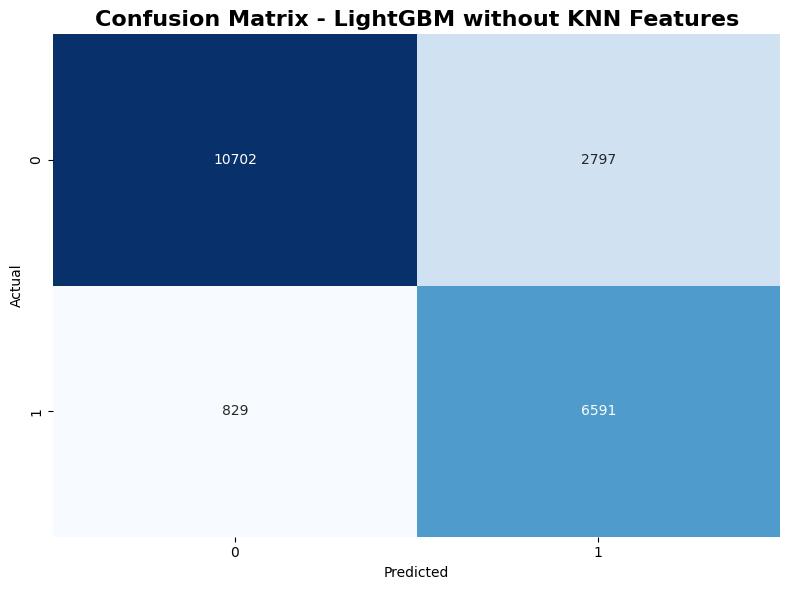

{'Accuracy': 0.8266647545293752, 'Precision': 0.702066467831274, 'Recall': 0.8882749326145553, 'F1-Score': 0.78426939552594, 'ROC-AUC': 0.8885829218855985}


In [68]:
import lightgbm as lgb

features = session_agg.columns

tr_data = lgb.Dataset(X_train_final, label=y_train)
model_lgbm_final = lgb.train({'eta': 0.05, 'objective': 'binary', 'max_leaves': 40}, tr_data, num_boost_round=500)
metrics_final, y_pred, y_pred_proba = lightgbm_metric(model_lgbm_final, X_test_final, y_test)
plot_confusion_matrix(y_test, y_pred, title='LightGBM without KNN Features')
print(metrics_final)

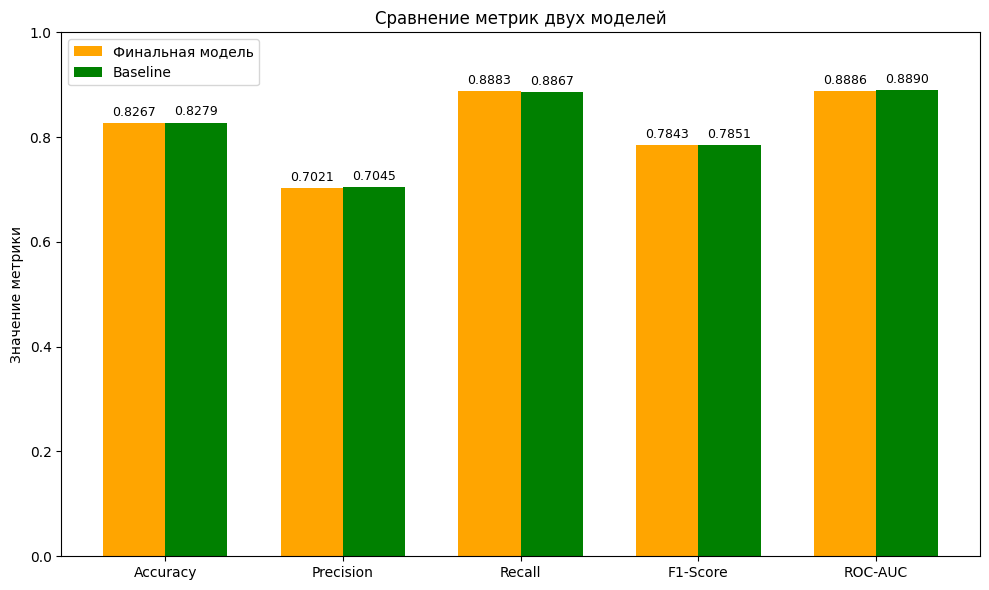

In [74]:
metrics = list(metrics_final.keys())
values1 = list(metrics_final.values())
values2 = list(metrics_baseline.values())

x = np.arange(len(metrics))  # позиции по оси X
width = 0.35  # ширина столбиков

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, values1, width, label='Финальная модель', color='orange')
bars2 = ax.bar(x + width/2, values2, width, label='Baseline', color='green')

# Подписи
ax.set_ylabel('Значение метрики')
ax.set_title('Сравнение метрик двух моделей')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.legend()

# Подписи над столбцами
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8706118	best: 0.8706118 (0)	total: 7.79ms	remaining: 4.43s
50:	test: 0.8855486	best: 0.8855486 (50)	total: 358ms	remaining: 3.64s
100:	test: 0.8864499	best: 0.8864499 (100)	total: 725ms	remaining: 3.37s
150:	test: 0.8868324	best: 0.8868324 (150)	total: 1.08s	remaining: 3.01s
200:	test: 0.8870708	best: 0.8871218 (194)	total: 1.45s	remaining: 2.66s
250:	test: 0.8872774	best: 0.8873762 (238)	total: 1.8s	remaining: 2.29s
300:	test: 0.8871731	best: 0.8873762 (238)	total: 2.17s	remaining: 1.94s
350:	test: 0.8869196	best: 0.8873762 (238)	total: 2.54s	remaining: 1.58s
400:	test: 0.8870212	best: 0.8873762 (238)	total: 2.89s	remaining: 1.22s
450:	test: 0.8871033	best: 0.8873762 (238)	total: 3.28s	remaining: 865ms
500:	test: 0.8871799	best: 0.8873762 (238)	total: 3.64s	remaining: 502ms
550:	test: 0.8872368	best: 0.8873762 (238)	total: 4.01s	remaining: 138ms
569:	test: 0.8872068	best: 0.8873762 (238)	total: 4.14s	remaining: 0us

bestTest = 0.8873762138
bestIteration = 238

Shrink model 

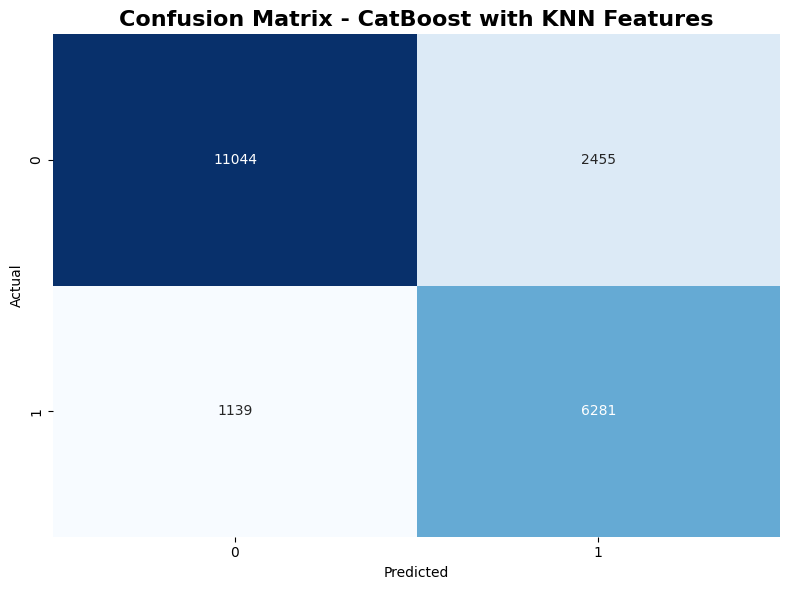

{'Accuracy': 0.8281944643625412, 'Precision': 0.7189789377289377, 'Recall': 0.8464959568733154, 'F1-Score': 0.7775439465214162, 'ROC-AUC': 0.8873762137516825}


In [69]:
train_pool = Pool(X_train_final, y_train)
valid_pool = Pool(X_test_final, y_test)

model_cb_final = CatBoostClassifier(score_function='Cosine',
                              depth=5,
                              eta=0.15,
                              eval_metric='AUC',
                              iterations=570,
                              verbose=50)

model_cb_final.fit(train_pool, eval_set=valid_pool, plot=True)

metrics_cb_final, y_pred_cb, y_pred_cb_proba = catboost_metric(model_cb_final, X_test_final, y_test )
plot_confusion_matrix(y_test, y_pred_cb, title='CatBoost with KNN Features')
print(metrics_cb_final)

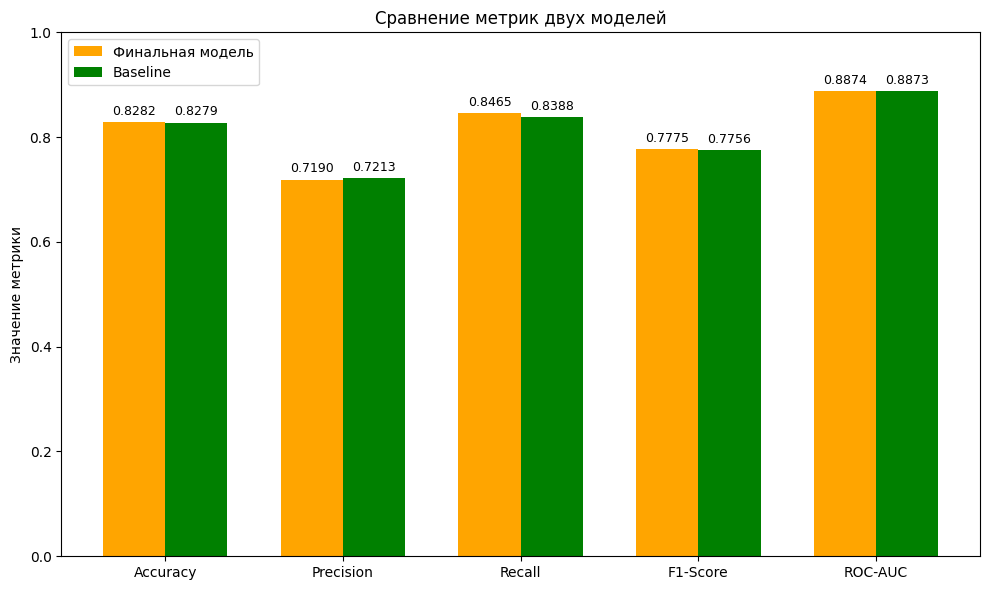

In [73]:
metrics = list(metrics_cb_final.keys())
values1 = list(metrics_cb_final.values())
values2 = list(metrics_cb_baseline.values())

x = np.arange(len(metrics))  # позиции по оси X
width = 0.35  # ширина столбиков

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, values1, width, label='Финальная модель', color='orange')
bars2 = ax.bar(x + width/2, values2, width, label='Baseline', color='green')

# Подписи
ax.set_ylabel('Значение метрики')
ax.set_title('Сравнение метрик двух моделей')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.legend()

# Подписи над столбцами
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()